In [1]:
from IPython.display import Image

# CNTK 106: Part A - Прогнозирование временных рядов с помощью LSTM (основы)

В этом учебном пособии показано, как использовать CNTK для прогнозирования будущих значений во временном ряду с использованием LSTM.

**Цель**

Мы используем смоделированный набор данных непрерывной функции (в нашем случае [sine wave](https://en.wikipedia.org/wiki/Sine)). Из `N` предыдущих значений функции $y = sin(t)$, где $y$  - наблюдаемый сигнал амплитуды в момент времени $t$, мы будем прогнозировать значения `M` и $y$ для соответствующих будущих временных точек.

In [2]:
# Рисунок 1
Image(url="http://www.cntk.ai/jup/sinewave.jpg")

В этом уроке мы будем использовать [LSTM](https://en.wikipedia.org/wiki/Long_short-term_memory) для реализации нашей модели. LSTM хорошо подходят для этой задачи, потому что способна обучаться. Подробнее о том, как работают LSTM, см. [this excellent post](http://colah.github.io/posts/2015-08-Understanding-LSTMs). 

В этом уроке мы будем иметь следующие подразделы:
- Моделирование генерируемых данных
- Сетевое моделирование LSTM
- Модельное обучение и оценка

Модельная подготовка и оценка. Эта модель работает для многих реальных данных. В части A этого руководства мы используем простую функцию sin (x), а в части B учебника (в настоящее время в разработке) мы будем использовать реальные данные с устройства IOT и пытаться прогнозировать ежедневный выход солнечной панели. 

In [3]:
import math
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
import time

import cntk as C
import cntk.tests.test_utils
cntk.tests.test_utils.set_device_from_pytest_env() # (only needed for our build system)

%matplotlib inline

Существует два режима работы:
- *Быстрый режим*: `isFast` установлен на `True`. Это режим по умолчанию для ноутбуков, что означает, что мы тренируемся за меньшее количество итераций по ограниченным данным. Это обеспечивает функциональную корректность ноутбука, хотя выпущенные модели далеки от того, что могло бы произвести завершенное обучение.

- *Медленный режим*:мы рекомендуем пользователю установить этот флаг в значение `False` , как только пользователь изучет материал ноутбука, и хочет получить представление о работе ноутбуков в течение более длительного периода с различными параметрами для обучения. 

In [4]:
isFast = True

## Генерация данных

Нам нужны несколько вспомогательных методов для генерации симулированных данных синусоидальной волны. Пусть `N` и `M`  - упорядоченное множество прошлых значений и будущих (желаемых прогнозируемых значений) синусоидальной волны соответственно.

- **`generate_data()`**

> В этом учебном пособии мы выбираем `N` последовательных значений `sin` функции в качестве входных данных для модели и пытаемся предсказать будущие значения, которые находятся на уровне `M` от последнего наблюдаемого значения во входной модели. Мы генерируем несколько таких экземпляров входного сигнала (путем выборки из функции `sin`) каждого размера `N` и соответствующего желаемого вывода в качестве наших данных обучения. Предполагая $k$ = batch size, функция `generate_data` выдает $X$ и соответствующие данные  $L$ и возвращает массивы следующей формы:

> Входной набор ($X$) в lstm: $$ X = [\{y_{11}, y_{12},  \cdots , y_{1N}\},
        \{y_{21}, y_{22}, \cdots, y_{2N}\}, \cdots,
        \{y_{k1}, y_{k2}, \cdots, y_{kN}\}]
$$

> В приведенных выше примерах $y_{i,j}$ представляет наблюдаемое значение функции для $i^{th}$ и $j^{th}$ временной точки в временном окне $N$ точек. 

> Желаемый результат ($L$) с шагами `M` в будущем: $$ L = [ \{y_{1,N+M}\},
        \{y_{2,N+M}\}, \cdots, \{y_{k,N+M}\}]$$

> Примечание: `k` является функцией длины временного ряда и количества окон размера `N`, которые могут иметься для временного ряда

- **`split_data()`**

> Как следует из названия, функция `split_data` будет разделять данные на обучающие, валидационные и тестовые наборы.

In [5]:
def split_data(data, val_size=0.1, test_size=0.1):
    """
    splits np.array into training, validation and test
    """
    pos_test = int(len(data) * (1 - test_size))
    pos_val = int(len(data[:pos_test]) * (1 - val_size))

    train, val, test = data[:pos_val], data[pos_val:pos_test], data[pos_test:]

    return {"train": train, "val": val, "test": test}

In [7]:
def generate_data(fct, x, time_steps, time_shift):
    """
    generate sequences to feed to rnn for fct(x)
    """
    data = fct(x)
    if not isinstance(data, pd.DataFrame):
        data = pd.DataFrame(dict(a = data[0:len(data) - time_shift],
                                 b = data[time_shift:]))
    rnn_x = []
    for i in range(len(data) - time_steps + 1):
        rnn_x.append(data['a'].iloc[i: i + time_steps].as_matrix())
    rnn_x = np.array(rnn_x)

    # Reshape or rearrange the data from row to columns
    # to be compatible with the input needed by the LSTM model
    # which expects 1 float per time point in a given batch
    rnn_x = rnn_x.reshape(rnn_x.shape + (1,))
    
    rnn_y = data['b'].values
    rnn_y = rnn_y[time_steps - 1 :]
    
    # Reshape or rearrange the data from row to columns
    # to match the input shape
    rnn_y = rnn_y.reshape(rnn_y.shape + (1,))

    return split_data(rnn_x), split_data(rnn_y)

Сгенерируем и визуализируем сгенерированные данные

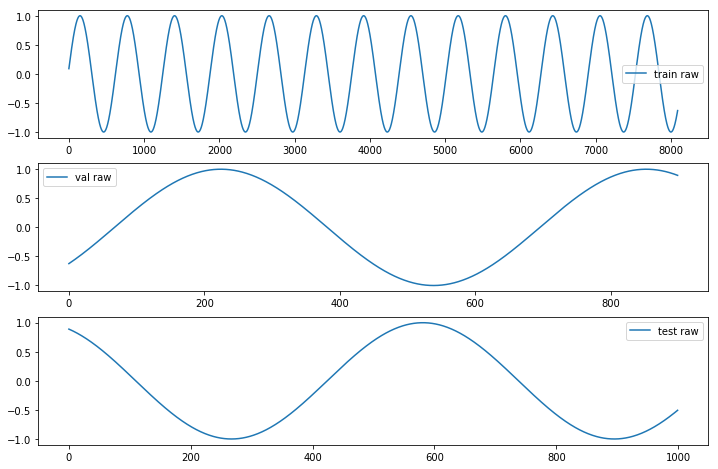

In [8]:
N = 5 # input: N subsequent values 
M = 5 # output: predict 1 value M steps ahead
X, Y = generate_data(np.sin, np.linspace(0, 100, 10000, dtype=np.float32), N, M)

f, a = plt.subplots(3, 1, figsize=(12, 8))
for j, ds in enumerate(["train", "val", "test"]):
    a[j].plot(Y[ds], label=ds + ' raw');
[i.legend() for i in a];

## Сетевое моделирование

Мы настраиваем нашу сеть с 1 ячейкой LSTM для каждого входа. У нас есть N входов, и каждый вход является значением нашей непрерывной функции. N выходов из LSTM являются входом в плотный слой, который производит один вывод.
Между LSTM и плотным слоем мы добавляем слой отсечки, который случайным образом снижает 20% значений, поступающих в LSTM, чтобы предотвратить переопределение модели в набор учебных данных. Мы хотим использовать слой отсечки во время обучения, но при использовании модели для прогнозирования мы не хотим отказываться от значений.
![lstm](https://www.cntk.ai/jup/cntk106A_model_s3.png)

In [9]:
def create_model(x):
    """Create the model for time series prediction"""
    with C.layers.default_options(initial_state = 0.1):
        m = C.layers.Recurrence(C.layers.LSTM(N))(x)
        m = C.sequence.last(m)
        m = C.layers.Dropout(0.2, seed=1)(m)
        m = C.layers.Dense(1)(m)
        return m

## Обучение сети

Мы определяем итератор `next_batch()` , который производит партии, которые мы можем передать в функцию обучения.
Обратите внимание, что поскольку CNTK поддерживает длину переменной последовательности, мы должны подавать партии в виде списка последовательностей. Это удобная функция для создания небольших партий данных, часто называемых мини-часами.

In [10]:
def next_batch(x, y, ds):
    """get the next batch to process"""

    def as_batch(data, start, count):
        part = []
        for i in range(start, start + count):
            part.append(data[i])
        return np.array(part)

    for i in range(0, len(x[ds])-BATCH_SIZE, BATCH_SIZE):
        yield as_batch(x[ds], i, BATCH_SIZE), as_batch(y[ds], i, BATCH_SIZE)

Настройте все, что нам нужно для обучения модели: определите заданные пользователем параметры обучения, определите входы, выходы, модель и оптимизатор.

In [11]:
# Training parameters

TRAINING_STEPS = 10000
BATCH_SIZE = 100
EPOCHS = 10 if isFast else 100

**Основные сведения**

Есть несколько ключевых знаний, когда [работает с последовательностями](https://www.cntk.ai/pythondocs/sequence.html) в сетях LSTM. Краткий обзор: 

Входы, выходы и параметры CNTK организованы в виде тензоров. Каждый тензор имеет ранг: скаляр является тензором ранга 0, вектор является тензором ранга 1, матрица является тензором ранга 2 и т. Д. Мы рассматриваем эти разные размеры как оси.

Каждый тензор CNTK имеет некоторые статические оси и некоторые динамические оси. Статические оси имеют одинаковую длину на протяжении всей жизни сети. Динамические оси похожи на статические оси, поскольку они определяют значимую группировку чисел, содержащихся в тензоре, но:
- их длина может варьироваться от экземпляра к экземпляру,
- их длина обычно не известна до того, как каждая minibatch представлена, и
- они могут быть заказаны.

В CNTK ось, над которой вы запускаете повторение, является динамической и, следовательно, ее размеры неизвестны в то время, когда вы определяете свою переменную. Таким образом, входная переменная отображает только фигуры статических осей. Поскольку наши входы представляют собой последовательность одномерных чисел, мы определяем входные данные как

> `C.sequence.input_variable(1)`

Экземпляры `N` наблюдаемой функции функции `sin` и соответствующая партия неявно представлены в динамической оси, как показано ниже, в форме значений по умолчанию. 

> ```
x_axes = [C.Axis.default_batch_axis(), C.Axis.default_dynamic_axis()]
C.input_variable(1, dynamic_axes=x_axes)
```
Читатель должен знать о значении параметров по умолчанию. Спецификация динамических осей позволяет механизму повторения обрабатывать данные временной последовательности в ожидаемом порядке. Пожалуйста, найдите время, чтобы понять, как работать как с статическими, так и с динамическими осями в CNTK, как описано [здесь](https://www.cntk.ai/pythondocs/sequence.html).

In [12]:
# input sequences
x = C.sequence.input_variable(1)

# create the model
z = create_model(x)

# expected output (label), also the dynamic axes of the model output
# is specified as the model of the label input
l = C.input_variable(1, dynamic_axes=z.dynamic_axes, name="y")

# the learning rate
learning_rate = 0.02
lr_schedule = C.learning_rate_schedule(learning_rate, C.UnitType.minibatch)

# loss function
loss = C.squared_error(z, l)

# use squared error to determine error for now
error = C.squared_error(z, l)

# use fsadagrad optimizer
momentum_time_constant = C.momentum_as_time_constant_schedule(BATCH_SIZE / -math.log(0.9)) 
learner = C.fsadagrad(z.parameters, 
                      lr = lr_schedule, 
                      momentum = momentum_time_constant, 
                      unit_gain = True)

trainer = C.Trainer(z, (loss, error), [learner])

Мы готовы тренироваться. 100 эпох должны давать приемлемые результаты.

In [13]:
# train
loss_summary = []
start = time.time()
for epoch in range(0, EPOCHS):
    for x1, y1 in next_batch(X, Y, "train"):
        trainer.train_minibatch({x: x1, l: y1})
    if epoch % (EPOCHS / 10) == 0:
        training_loss = trainer.previous_minibatch_loss_average
        loss_summary.append(training_loss)
        print("epoch: {}, loss: {:.5f}".format(epoch, training_loss))

print("training took {0:.1f} sec".format(time.time() - start))

epoch: 0, loss: 0.47786
epoch: 1, loss: 0.13716
epoch: 2, loss: 0.09105
epoch: 3, loss: 0.06731
epoch: 4, loss: 0.07279
epoch: 5, loss: 0.05649
epoch: 6, loss: 0.07282
epoch: 7, loss: 0.05344
epoch: 8, loss: 0.05083
epoch: 9, loss: 0.03765
training took 9.9 sec


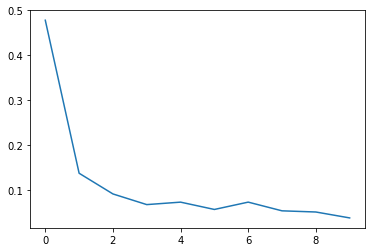

In [14]:
# Посмотрите, как функция потерь показывает, насколько хорошо модель сходится
plt.plot(loss_summary, label='training loss');

Обычно мы проверяем подготовку данных, которые мы откладываем для проверки, но поскольку входные данные малы, мы можем запускать validation во всех частях набора данных.

In [15]:
# validate
def get_mse(X,Y,labeltxt):
    result = 0.0
    for x1, y1 in next_batch(X, Y, labeltxt):
        eval_error = trainer.test_minibatch({x : x1, l : y1})
        result += eval_error
    return result/len(X[labeltxt])

In [16]:
# Print the train and validation errors
for labeltxt in ["train", "val"]:
    print("mse for {}: {:.6f}".format(labeltxt, get_mse(X, Y, labeltxt)))

mse for train: 0.000059
mse for val: 0.000048


In [17]:
# Print validate and test error
labeltxt = "test"
print("mse for {}: {:.6f}".format(labeltxt, get_mse(X, Y, labeltxt)))

mse for test: 0.000050


Поскольку мы использовали простую функцию sin (x), мы должны ожидать, что ошибки будут одинаковыми для наборов для поездов, валидации и испытаний. Для реальных наборов данных, которые будут разными, конечно. Мы также намечаем ожидаемый результат (Y) и прогноз, который наша модель сделала, чтобы показать, насколько хорошо работает простой подход LSTM.

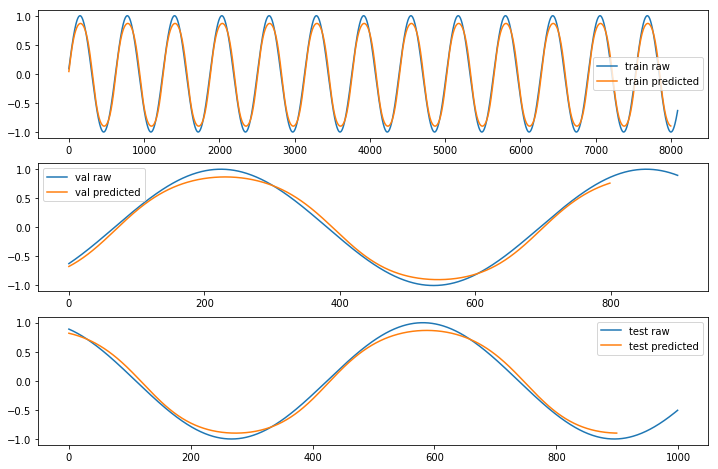

In [18]:
# predict
f, a = plt.subplots(3, 1, figsize = (12, 8))
for j, ds in enumerate(["train", "val", "test"]):
    results = []
    for x1, y1 in next_batch(X, Y, ds):
        pred = z.eval({x: x1})
        results.extend(pred[:, 0])
    a[j].plot(Y[ds], label = ds + ' raw');
    a[j].plot(results, label = ds + ' predicted');
[i.legend() for i in a];

Не идеально, но достаточно близко, учитывая простоту модели.

Здесь мы использовали простую греховную волну, но вы можете возиться и попробовать другие данные временных рядов. `generate_data()` позволяет передавать в dataframe столбцы 'a' и 'b' место функции.

Чтобы улучшить результаты, мы могли тренироваться с большим количеством точек данных, позволять модели тренироваться в течение более эпох или улучшать саму модель.